# Databased used
- CREMA-D: 7,442 clips
- RAVDESS: 2,880 clips
- TESS: 2,000 clips
- SAVEE: 480 clips

This provides a total of **12,802** inputs overall, with 7 emotions (anger, disgust, fear, happy, neutral, sad, suprise).

In [ ]:
# Import libraries
# KERNEL SETUP IN VS CODE:
# conda create -n myenv python=3.12.2
# conda activate myenv

%pip install resampy tf_keras tensorflow librosa pandas matplotlib kagglehub seaborn

import IPython.display as ipd
from IPython.display import Audio
import kagglehub
import librosa
from librosa import feature
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

In [ ]:
# Datasets via kagglehub

cremad = kagglehub.dataset_download("ejlok1/cremad")
print("CREMA-D to dataset files:", cremad)

ravdess = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("RAVDESS to dataset files:", ravdess)

tess = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print("RAVDESS to dataset files:", tess)

savee = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")
print("RAVDESS to dataset files:", savee)

# Pre-processing
## CREMA-D

In [ ]:
# Load CREMA-D Dataset
paths = []
emotions = []

for dirname, _, filenames in os.walk(cremad): # (dirname, subdirs, filenames)
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            emotion = filename.split('_')[2]  # Get the emotion code (e.g., 'ANG')
            emotions.append(emotion)

print(paths[:5])

print(emotions[:5])

# Create DataFrame
cremad_df = pd.DataFrame()
cremad_df['paths'] = paths
cremad_df['emotions'] = emotions

# Map emotion codes to full emotions
emotion_map = {
    'ANG': 'anger',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad'
}

cremad_df['emotions'] = cremad_df['emotions'].map(emotion_map)

print(cremad_df.head())

print(cremad_df['emotions'].value_counts())

## RAVEDESS

In [ ]:
paths = []
emotions = []

for dirname, _, filenames in os.walk(ravdess): # (dirname, subdirs, filenames)
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            part = filename.split('.')[0].split('-')  # Get the emotion number (e.g., '03' = happy)
            emotions.append(int(part[2]))


print(paths[:5])
print(emotions[:5])

# Create DataFrame
ravdess_df = pd.DataFrame()
ravdess_df['paths'] = paths
ravdess_df['emotions'] = emotions


# Map emotion codes to full emotions
emotion_map = {
    1 : 'neutral',
    2 : 'neutral', # calm as neutral to balance dataset
    3 : 'happy',
    4 : 'sad',
    5 : 'anger',
    6 : 'fear',
    7 : 'disgust',
    8 : 'suprise'

}

ravdess_df['emotions'] = ravdess_df['emotions'].map(emotion_map)

print(ravdess_df.head())

print(ravdess_df['emotions'].value_counts())

## TESS

In [ ]:
paths = []
emotions = []

for dirname, _, filenames in os.walk(tess): # (dirname, subdirs, filenames)
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            emotion = filename.split('.')[0].split('_')[2]  # Get the emotion code (e.g., 'ANG')
            emotions.append(emotion)

print(paths[:5])

print(emotions[:5])

# Create DataFrame
tess_df = pd.DataFrame()
tess_df['paths'] = paths
tess_df['emotions'] = emotions

# Map emotion codes to full emotions
emotion_map = {
    'angry': 'anger',
    'disgust': 'disgust',
    'fear': 'fear',
    'happy': 'happy',
    'neutral': 'neutral',
    'ps' : 'suprise',
    'sad' : 'sad'
}

tess_df['emotions'] = tess_df['emotions'].map(emotion_map)

print(tess_df.head())

print(tess_df['emotions'].value_counts())

## SAVEE

In [ ]:
paths = []
emotions = []

for dirname, _, filenames in os.walk(savee): # (dirname, subdirs, filenames)
    for filename in filenames:
        if filename.endswith('.wav'):
            paths.append(os.path.join(dirname, filename))
            part = filename.split('_')[1]  # Get the emotion code (e.g., 'ANG')
            emotion = part[:-6]
            emotions.append(emotion)

print(paths[:5])

print(emotions[:5])

# Create DataFrame
savee_df = pd.DataFrame()
savee_df['paths'] = paths
savee_df['emotions'] = emotions

emotion_map = {
    'n': 'neutral',
    'd': 'disgust',
    'a': 'anger',
    'f': 'fear',
    'h': 'happy',
    'sa': 'sad',
    'su' : 'suprise'
}

savee_df['emotions'] = savee_df['emotions'].map(emotion_map)

print(savee_df.head())

print(savee_df['emotions'].value_counts())

# Integration

In [ ]:
emotion_data = pd.concat([cremad_df, ravdess_df, tess_df, savee_df], axis = 0)

emotion_data.to_csv("emotion_data.csv", index=False)

print(emotion_data.emotions.value_counts())

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Emotions Count', size=16)
sns.countplot(emotion_data.emotions)
plt.xlabel('Count', size=12)
plt.ylabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Data Visualition

## Load

In [ ]:
data, sr = librosa.load(paths[0], sr=None) #Latest path value from SAVEE (angry)
print(emotions[0])
ipd.Audio(data,rate=sr)

## Mel Spectogram

In [ ]:
n_mels = 128
n_fft = 2048
hop_length = 512
fmax = 8000
mel_spectogram = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)

log_mel_spectogram = librosa.power_to_db(mel_spectogram)

plt.figure(figsize=(10, 6))
librosa.display.specshow(log_mel_spectogram, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectogram')
plt.show()

## MFCC

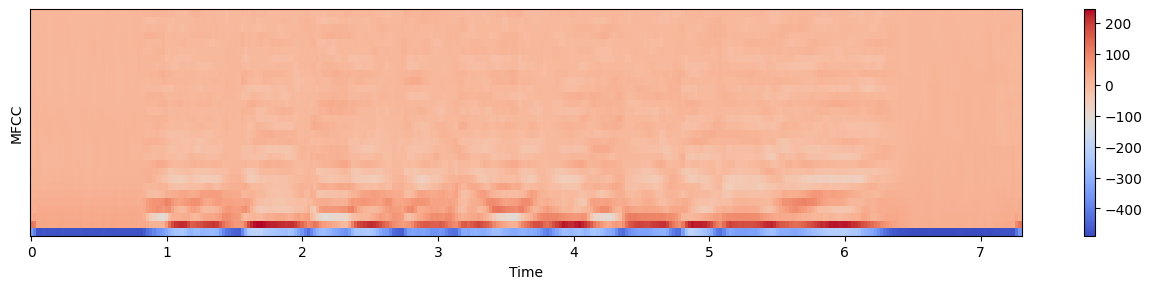

In [26]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)

plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

# Data Augmentation